# Performance Analysis Notebook

We use this notebook to evaluate the performance of the UNET Model. The model should already be trained, and be saved. We evaluate key metrics like IoU on the test set to judge the performance of the UNET. We will also visuailze the predictions and ground truth side by side. Finally we will predict lanes on challenging videos for a realistic visualization.

This notebook contains the below listed important sections:
- Loading Data
- Visualizing the Dataset
- Loading UNET
- Normalizing Images
- Predicting on the Test Subset
- Visualizing Predictions
- Calculate Intersection over Union (IoU)

## Loading Data

In [34]:
# Import packages from those installed in conda environment
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import seaborn as sns

from keras import Model
from tqdm import tqdm

In [19]:
sys.path.append("..")
from src.predict import calculate_iou

In [20]:
# Load data stored in pickle files as numpy arrays
dataset_images = np.array(pickle.load(open("../data/full_CNN_train.p", 'rb')))
dataset_labels = np.array(pickle.load(open("../data/full_CNN_labels.p", 'rb')))

## Visualizing the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No. of dataset images: 12764 of shape: (80, 160, 3)
No. of dataset labels: 12764 of shape: (80, 160, 1)


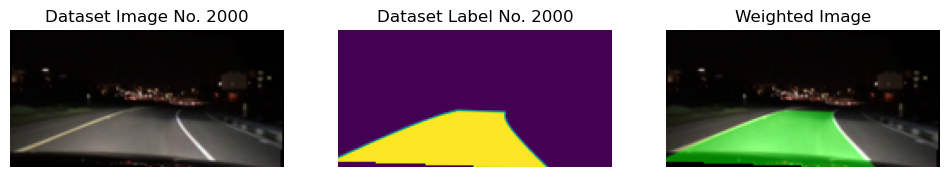

In [21]:
# Print dimensions of the dataset and image types
print(f"No. of dataset images: {len(dataset_images)} of shape: {dataset_images.shape[1:]}")
print(f"No. of dataset labels: {len(dataset_labels)} of shape: {dataset_labels.shape[1:]}")

# Change image_index number to view different images and their respective labels. 
# NOTE: Make sure index is less than the length of the dataset and more than 0
image_index = 2000

# Load original image and label based on image_index
image_weighted = dataset_images[image_index] / 255
label = dataset_labels[image_index] / 255

# Pre-multiplication
a_channel_label = np.ones(label.shape, dtype=np.float64)/2.0
label *= a_channel_label
label = np.reshape(label, (80, 160))

# Overlay the label on top of the original image
image_weighted[:,:,1] += (label)

# Create a Figure object with a specific size
fig = plt.figure(figsize=[12,7])

# Display original image
fig.add_subplot(1, 3, 1)
plt.imshow(dataset_images[image_index])
plt.axis("off")
plt.title(f"Dataset Image No. {image_index}")

# Display corresponding label / ground truth
fig.add_subplot(1, 3, 2)
plt.imshow(dataset_labels[image_index])
plt.axis("off")
plt.title(f"Dataset Label No. {image_index}")

# Display weighted image
fig.add_subplot(1, 3, 3)
plt.imshow(image_weighted)
plt.axis("off")
plt.title(f"Weighted Image")

plt.show()

## Loading UNET

In [22]:
# Load saved model
my_unet: Model = tf.keras.models.load_model('../keras.model')
my_unet.summary()

2023-09-04 22:24:44.527626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 22:24:44.785310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 22:24:44.785990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 80, 160, 16)  448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 80, 160, 16)  2320        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 40, 80, 16)   0           ['conv2d_1[0][0]']           

## Normalizing Images

In [41]:
images_test = np.array(dataset_images[6000:]) / 255
labels_test = np.array(dataset_labels[6000:]) / 255

6764


## Predicting on the Test Subset

In [24]:
predictions = my_unet.predict(images_test)


2023-09-04 22:24:47.956824: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1038950400 exceeds 10% of free system memory.
2023-09-04 22:24:48.868449: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1038950400 exceeds 10% of free system memory.
2023-09-04 22:24:49.782156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800


212/212 [==============================] - 9s 29ms/step


In [61]:
binarized_labels = np.where(labels_test > 0.5, 1, 0)
binarized_predictions = np.where(predictions > 0.5, 1, 0)

## Visualizing Predictions

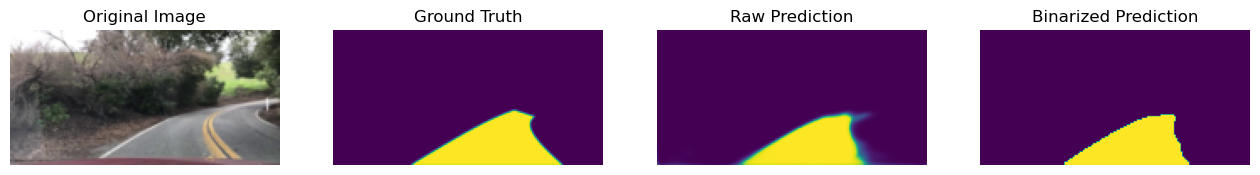

In [65]:
prediction_index = 2000
fig = plt.figure(figsize=(16, 8))

fig.add_subplot(1,4,1)
plt.imshow(images_test[prediction_index])
plt.axis("off")
plt.title("Original Image")

fig.add_subplot(1,4,2)
plt.imshow(labels_test[prediction_index])
plt.axis("off")
plt.title("Ground Truth")

fig.add_subplot(1,4,3)
plt.imshow(predictions[prediction_index])
plt.axis("off")
plt.title("Raw Prediction")

fig.add_subplot(1,4,4)
plt.imshow(binarized_predictions[prediction_index])
plt.axis("off")
plt.title("Binarized Prediction")

plt.show()

## Calculate Intersection over Union (IoU)

In [43]:
iou = []
for y_true, y_pred in tqdm(list(zip(binarized_labels, binarized_predictions))):
    iou.append(calculate_iou(y_true, y_pred))

100%|██████████| 6764/6764 [06:03<00:00, 18.59it/s]


### Mean IoU for 6,764 test images is 92.18%

In [59]:
print(f"Mean IoU of Test Subset: {np.mean(iou)}")

Mean IoU of Test Subset: 0.9218356888343918


/home/lonewolf/mambaforge/envs/lane_segmentation/lib/python3.9/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lonewolf/mambaforge/envs/lane_segmentation/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lonewolf/mambaforge/envs/lane_segmentation/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


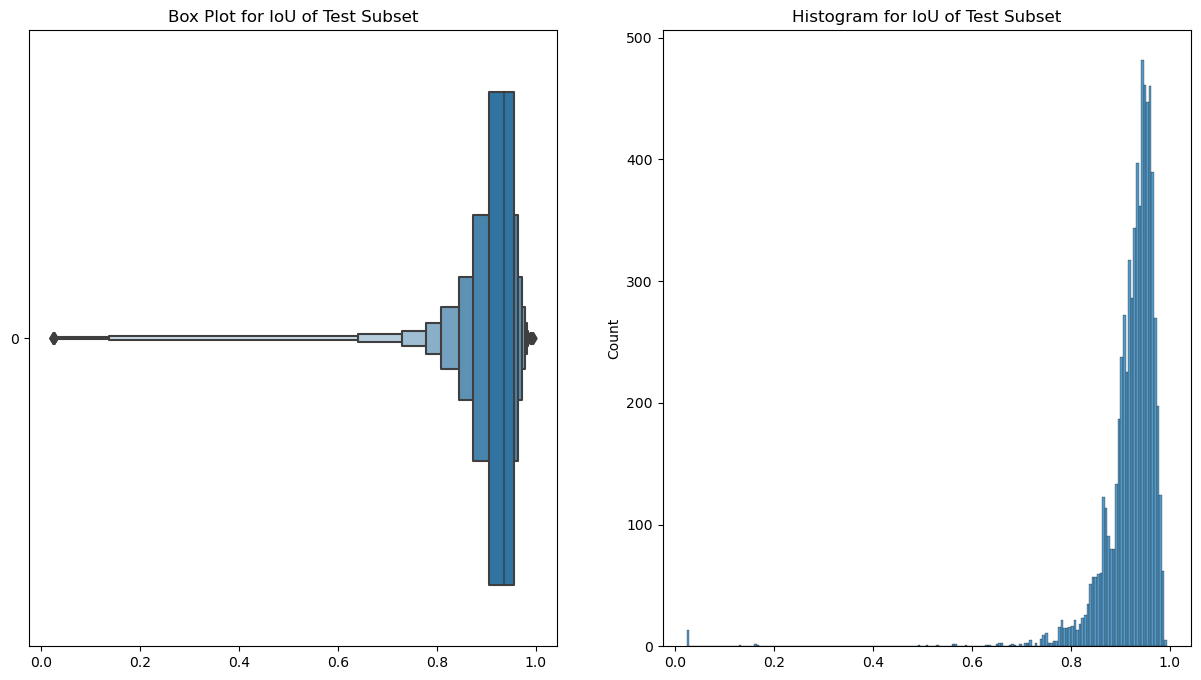

In [58]:
fig = plt.figure(figsize=[15,8])

fig.add_subplot(1,2,1)
sns.boxenplot(iou, orient='h')
plt.title("Box Plot for IoU of Test Subset")

fig.add_subplot(1,2,2)
sns.histplot(iou)
plt.title("Histogram for IoU of Test Subset")

plt.show()